In [4]:
import torch
import matplotlib.pyplot as plt
import sys
import os
from network import InfModel

folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = 'local_pruned_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = os.path.join(dir_name, folder_name)
model_path = os.path.join(folder_path, model_name)

# 모델 로드
model = torch.load(model_path)
inf_model = InfModel(model, "cifar10")
analog_model = inf_model.ConvertModel()

In [7]:
for tensors in analog_model.get_weights():
    print("Tensors :", tensors)
    print(type(tensors))

Tensors : conv1.analog_module
<class 'str'>
Tensors : layer1.0.conv1.analog_module
<class 'str'>
Tensors : layer1.0.conv2.analog_module
<class 'str'>
Tensors : layer1.1.conv1.analog_module
<class 'str'>
Tensors : layer1.1.conv2.analog_module
<class 'str'>
Tensors : layer2.0.conv1.analog_module
<class 'str'>
Tensors : layer2.0.conv2.analog_module
<class 'str'>
Tensors : layer2.0.downsample.0.analog_module
<class 'str'>
Tensors : layer2.1.conv1.analog_module
<class 'str'>
Tensors : layer2.1.conv2.analog_module
<class 'str'>
Tensors : layer3.0.conv1.analog_module
<class 'str'>
Tensors : layer3.0.conv2.analog_module
<class 'str'>
Tensors : layer3.0.downsample.0.analog_module
<class 'str'>
Tensors : layer3.1.conv1.analog_module
<class 'str'>
Tensors : layer3.1.conv2.analog_module
<class 'str'>
Tensors : layer4.0.conv1.analog_module
<class 'str'>
Tensors : layer4.0.conv2.analog_module
<class 'str'>
Tensors : layer4.0.downsample.0.analog_module
<class 'str'>
Tensors : layer4.1.conv1.analog_mo

In [11]:
for name, param in model.named_parameters():
    if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
        if "fc" in name or len(param.size()) == 2:  # Fully Connected Layer
            print("fc: ", name)
        elif "conv" in name or len(param.size()) == 4:  # Convolutional Layer
            print("conv: ", name)

conv:  conv1.weight
conv:  layer1.0.conv1.weight
conv:  layer1.0.conv2.weight
conv:  layer1.1.conv1.weight
conv:  layer1.1.conv2.weight
conv:  layer2.0.conv1.weight
conv:  layer2.0.conv2.weight
conv:  layer2.0.downsample.0.weight
conv:  layer2.1.conv1.weight
conv:  layer2.1.conv2.weight
conv:  layer3.0.conv1.weight
conv:  layer3.0.conv2.weight
conv:  layer3.0.downsample.0.weight
conv:  layer3.1.conv1.weight
conv:  layer3.1.conv2.weight
conv:  layer4.0.conv1.weight
conv:  layer4.0.conv2.weight
conv:  layer4.0.downsample.0.weight
conv:  layer4.1.conv1.weight
conv:  layer4.1.conv2.weight
fc:  fc.weight


In [43]:
for name, param in model.named_parameters():
    if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
        print(f"Layer: {name}, Shape: {param.shape}, Size: {len(param.size())}")

Layer: conv1.weight, Shape: torch.Size([64, 3, 3, 3]), Size: 4
Layer: layer1.0.conv1.weight, Shape: torch.Size([64, 64, 3, 3]), Size: 4
Layer: layer1.0.conv2.weight, Shape: torch.Size([64, 64, 3, 3]), Size: 4
Layer: layer1.1.conv1.weight, Shape: torch.Size([64, 64, 3, 3]), Size: 4
Layer: layer1.1.conv2.weight, Shape: torch.Size([64, 64, 3, 3]), Size: 4
Layer: layer2.0.conv1.weight, Shape: torch.Size([128, 64, 3, 3]), Size: 4
Layer: layer2.0.conv2.weight, Shape: torch.Size([128, 128, 3, 3]), Size: 4
Layer: layer2.0.downsample.0.weight, Shape: torch.Size([128, 64, 1, 1]), Size: 4
Layer: layer2.1.conv1.weight, Shape: torch.Size([128, 128, 3, 3]), Size: 4
Layer: layer2.1.conv2.weight, Shape: torch.Size([128, 128, 3, 3]), Size: 4
Layer: layer3.0.conv1.weight, Shape: torch.Size([256, 128, 3, 3]), Size: 4
Layer: layer3.0.conv2.weight, Shape: torch.Size([256, 256, 3, 3]), Size: 4
Layer: layer3.0.downsample.0.weight, Shape: torch.Size([256, 128, 1, 1]), Size: 4
Layer: layer3.1.conv1.weight, Sha

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from network import InfModel

inf_model = InfModel(model, "cifar10")
rpu_config = inf_model.SetConfig()
analog_model = inf_model.ConvertModel()

for name, param in model.named_parameters():
    if name == "layer1.0.conv1.weight":
        weights = param.data.cpu()
        print(f"Layer: {name}, Weight Min: {weights.min().item()}, Max: {weights.max().item()}")  

        # Conductance 변환 수행
        conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
        gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환

        # 변환 후 값 확인
        print(f"Conductance Gp Min: {gp.min().item()}, Max: {gp.max().item()}")
        print(f"Conductance Gm Min: {gm.min().item()}, Max: {gm.max().item()}")

        # 0이 아닌 값들만 필터링
        gp_nonzero = gp[gp > 0]
        gm_nonzero = gm[gm > 0]

        if gp_nonzero.numel() == 0:
            print("Gp has only zeros!")
        if gm_nonzero.numel() == 0:
            print("Gm has only zeros!")


Layer: layer1.0.conv1.weight, Weight Min: -0.06962092220783234, Max: 0.0570538230240345
Conductance Gp Min: 0.0, Max: 20.48731231689453
Conductance Gm Min: 0.0, Max: 25.0


In [25]:
gp

tensor([[[[2.2551, 1.8474, 0.0000],
          [9.9944, 9.5956, 6.1060],
          [0.0000, 0.5084, 0.0000]],

         [[0.8205, 5.6218, 3.9252],
          [1.3712, 5.6487, 5.8839],
          [1.6442, 5.0126, 7.3368]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5088, 0.6506],
          [0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000],
          [5.2024, 6.4622, 4.0856],
          [4.0103, 5.8225, 3.2814]],

         [[0.0000, 1.8767, 0.0000],
          [1.5007, 4.4959, 2.0774],
          [1.2205, 2.7139, 1.4258]],

         [[1.2745, 2.2185, 1.7382],
          [2.9788, 3.6689, 2.6589],
          [0.0000, 1.3872, 0.6146]]],


        [[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [2.7199, 0.0000, 0.0000]],

         [[0.5834, 0.0000, 2.0082],
          [0.0000, 0.0000, 0.0000],
          [0.5773, 0.0000, 1.6464]],

         [[3.3866, 2.3633, 0.0000],
          [2.4094, 2.4870, 0.0000],
          [3.1627, 2.5455, 0.00

In [26]:
gp.flatten()

tensor([2.2551, 1.8474, 0.0000,  ..., 1.1024, 2.3400, 1.2600])

In [27]:
gm.flatten()

tensor([0.0000, 0.0000, 0.4221,  ..., 0.0000, 0.0000, 0.0000])

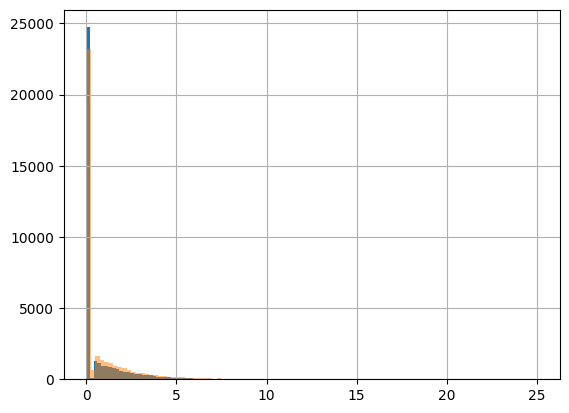

In [32]:
plt.hist(gp.flatten(), bins=100, alpha=1, label="Gp")
plt.hist(gm.flatten(), bins=100, alpha=0.5, label="Gm")
plt.grid(True)
# plt.yscale('log')

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Conductance 변환 함수 (FC / Conv 분리)
def convert_weights_to_conductance(model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    min_gp_fc, min_gm_fc = None, None
    min_gp_conv, min_gm_conv = None, None

    for name, param in model.named_parameters():
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()
            
            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환

            if len(param.size()) == 4:  # Convolutional Layer
                conductance_list_conv.append((gp.flatten(), gm.flatten()))
                
            elif len(param.size()) == 2:  # Fully Connected Layer
                conductance_list_fc.append((gp.flatten(), gm.flatten()))

    return conductance_list_fc, conductance_list_conv


In [48]:
g_fc, g_conv = convert_weights_to_conductance(analog_model, rpu_config)

In [50]:
g_fc

[(tensor([3.8355, 9.5919, 5.2561,  ..., 0.0000, 1.1982, 0.0000]),
  tensor([0.0000, 0.0000, 0.0000,  ..., 1.2208, 0.0000, 0.0000])),
 (tensor([2.2551, 1.8474, 0.0000,  ..., 1.1024, 2.3400, 1.2600]),
  tensor([0.0000, 0.0000, 0.4221,  ..., 0.0000, 0.0000, 0.0000])),
 (tensor([1.6702, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]),
  tensor([0.0000, 0.0000, 0.0000,  ..., 4.6494, 0.0000, 0.0000])),
 (tensor([4.1522, 2.4102, 1.2959,  ..., 0.0000, 2.0292, 0.0000]),
  tensor([0.0000, 0.0000, 0.0000,  ..., 2.0190, 0.0000, 0.0000])),
 (tensor([3.6468, 5.5546, 0.0000,  ..., 0.0000, 0.0000, 4.3425]),
  tensor([0.0000, 0.0000, 0.0000,  ..., 4.1632, 3.5297, 0.0000])),
 (tensor([2.9174, 4.6611, 0.0000,  ..., 2.0716, 0.0000, 0.0000]),
  tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.5907, 0.0000])),
 (tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.6562, 1.7294]),
  tensor([6.5752, 0.0000, 1.4366,  ..., 1.8976, 0.0000, 0.0000])),
 (tensor([7.4831, 0.0000, 0.0000,  ..., 5.7906, 0.0000, 0.0000]),
  t

In [36]:
gp_fc_all = np.concatenate([gp for gp, _ in g_fc]) if g_fc else np.array([])

In [37]:
gp_fc_all

array([ 3.8355405,  9.591926 ,  5.2560782, ...,  7.383723 ,  0.       ,
       14.215082 ], dtype=float32)

In [38]:
gp_conv_all = np.concatenate([gp for gp, _ in g_conv]) if g_conv else np.array([])
gp_conv_all

array([], dtype=float64)

In [49]:
g_conv

[]

In [ ]:
def convert_weights_to_conductance(analog_model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    for name, param in analog_model.named_parameters():  #  analog_model에서 weight 가져오기
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()

            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환

            # 0이 아닌 값 확인
            gp_nonzero = gp[gp > 0]
            gm_nonzero = gm[gm > 0]

            print(f"Layer: {name}, Gp Min: {gp.min().item()}, Max: {gp.max().item()}, Nonzero count: {gp_nonzero.numel()}")
            print(f"Layer: {name}, Gm Min: {gm.min().item()}, Max: {gm.max().item()}, Nonzero count: {gm_nonzero.numel()}")

            if len(param.size()) == 4:  # Convolutional Layer
                if gp_nonzero.numel() > 0 or gm_nonzero.numel() > 0:  # ✅ 0이 아닌 값이 있는 경우만 저장
                    conductance_list_conv.append((gp.flatten(), gm.flatten()))

            elif len(param.size()) == 2:  # Fully Connected Layer
                if gp_nonzero.numel() > 0 or gm_nonzero.numel() > 0:
                    conductance_list_fc.append((gp.flatten(), gm.flatten()))

    return conductance_list_fc, conductance_list_conv

# 실행
g_fc, g_conv = convert_weights_to_conductance(analog_model, rpu_config)
print(f"Conv Conductance Count: {len(g_conv)}")


Layer: conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 23.057903289794922, Nonzero count: 599
Layer: conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonzero count: 611
Layer: layer1.0.conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 20.48731231689453, Nonzero count: 12142
Layer: layer1.0.conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonzero count: 13663
Layer: layer1.0.conv2.analog_module.shared_weights, Gp Min: 0.0, Max: 25.0, Nonzero count: 11993
Layer: layer1.0.conv2.analog_module.shared_weights, Gm Min: 0.0, Max: 22.807621002197266, Nonzero count: 13812
Layer: layer1.1.conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 25.0, Nonzero count: 11854
Layer: layer1.1.conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 22.523347854614258, Nonzero count: 13951
Layer: layer1.1.conv2.analog_module.shared_weights, Gp Min: 0.0, Max: 20.688251495361328, Nonzero count: 11481
Layer: layer1.1.conv2.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonz

In [52]:
def convert_weights_to_conductance(analog_model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    for name, param in analog_model.named_parameters():  # ✅ 변환된 모델에서 weight 가져오기
        if "analog_module.shared_weights" in name:  # ✅ analog_model의 shared_weights만 선택
            weights = param.data.cpu()
            print(f"Layer: {name}, Shape: {weights.shape}, Weight Min: {weights.min().item()}, Max: {weights.max().item()}")  

            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환

            # 0이 아닌 값 확인
            gp_nonzero = gp[gp > 0]
            gm_nonzero = gm[gm > 0]

            print(f"Layer: {name}, Gp Min: {gp.min().item()}, Max: {gp.max().item()}, Nonzero count: {gp_nonzero.numel()}")
            print(f"Layer: {name}, Gm Min: {gm.min().item()}, Max: {gm.max().item()}, Nonzero count: {gm_nonzero.numel()}")

            # ✅ Conv / FC 분리 (shared_weights는 3D로 나올 가능성 있음)
            if len(weights.shape) >= 3:  # ✅ shared_weights에 맞게 수정
                conductance_list_conv.append((gp.flatten(), gm.flatten()))
            elif len(weights.shape) == 2:  # Fully Connected Layer
                conductance_list_fc.append((gp.flatten(), gm.flatten()))

    print(f"✅ Conv Conductance Count: {len(conductance_list_conv)}")
    print(f"✅ FC Conductance Count: {len(conductance_list_fc)}")

    return conductance_list_fc, conductance_list_conv

# 실행
g_fc, g_conv = convert_weights_to_conductance(analog_model, rpu_config)


Layer: conv1.analog_module.shared_weights, Shape: torch.Size([64, 27]), Weight Min: -1.0, Max: 0.9223161339759827
Layer: conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 23.057903289794922, Nonzero count: 599
Layer: conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonzero count: 611
Layer: layer1.0.conv1.analog_module.shared_weights, Shape: torch.Size([64, 576]), Weight Min: -1.0, Max: 0.819492518901825
Layer: layer1.0.conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 20.48731231689453, Nonzero count: 12142
Layer: layer1.0.conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonzero count: 13663
Layer: layer1.0.conv2.analog_module.shared_weights, Shape: torch.Size([64, 576]), Weight Min: -0.9123048782348633, Max: 1.0
Layer: layer1.0.conv2.analog_module.shared_weights, Gp Min: 0.0, Max: 25.0, Nonzero count: 11993
Layer: layer1.0.conv2.analog_module.shared_weights, Gm Min: 0.0, Max: 22.807621002197266, Nonzero count: 13812
Layer: layer1.1.conv1.analog_module.sh

In [53]:
def convert_weights_to_conductance(analog_model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    for name, param in analog_model.named_parameters():
        if "analog_module.shared_weights" in name:  # ✅ 변환된 모델의 shared_weights만 선택
            weights = param.data.cpu()
            print(f"Layer: {name}, Shape: {weights.shape}, Weight Min: {weights.min().item()}, Max: {weights.max().item()}")

            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            gp, gm = conductance_pair[0]

            # 0이 아닌 값 확인
            gp_nonzero = gp[gp > 0]
            gm_nonzero = gm[gm > 0]

            print(f"Layer: {name}, Gp Min: {gp.min().item()}, Max: {gp.max().item()}, Nonzero count: {gp_nonzero.numel()}")
            print(f"Layer: {name}, Gm Min: {gm.min().item()}, Max: {gm.max().item()}, Nonzero count: {gm_nonzero.numel()}")

            # ✅ Conv와 FC 구별하는 새로운 방법 추가
            if "fc" in name or weights.shape[0] <= 10:  # FC 레이어
                conductance_list_fc.append((gp.flatten(), gm.flatten()))
            else:  # Conv 레이어 (shared_weights 형태 적용)
                conductance_list_conv.append((gp.flatten(), gm.flatten()))

    print(f"✅ Conv Conductance Count: {len(conductance_list_conv)}")
    print(f"✅ FC Conductance Count: {len(conductance_list_fc)}")

    return conductance_list_fc, conductance_list_conv

# 실행
g_fc, g_conv = convert_weights_to_conductance(analog_model, rpu_config)


Layer: conv1.analog_module.shared_weights, Shape: torch.Size([64, 27]), Weight Min: -1.0, Max: 0.9223161339759827
Layer: conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 23.057903289794922, Nonzero count: 599
Layer: conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonzero count: 611
Layer: layer1.0.conv1.analog_module.shared_weights, Shape: torch.Size([64, 576]), Weight Min: -1.0, Max: 0.819492518901825
Layer: layer1.0.conv1.analog_module.shared_weights, Gp Min: 0.0, Max: 20.48731231689453, Nonzero count: 12142
Layer: layer1.0.conv1.analog_module.shared_weights, Gm Min: 0.0, Max: 25.0, Nonzero count: 13663
Layer: layer1.0.conv2.analog_module.shared_weights, Shape: torch.Size([64, 576]), Weight Min: -0.9123048782348633, Max: 1.0
Layer: layer1.0.conv2.analog_module.shared_weights, Gp Min: 0.0, Max: 25.0, Nonzero count: 11993
Layer: layer1.0.conv2.analog_module.shared_weights, Gm Min: 0.0, Max: 22.807621002197266, Nonzero count: 13812
Layer: layer1.1.conv1.analog_module.sh